# Ecological Index - regional average values
- Plot "present day" bar plot of regional area weighted average values inside and outside polynyas
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# keep and convert tarea to km2 from cm2
tarea = ds_grid.TAREA/((100*100)*(1000*1000))

## Load the Present Day Ecoindex Data

In [7]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

In [8]:
file_in = 'ecoindex_present_day.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

In [9]:
ds_eco

<xarray.Dataset>
Dimensions:               (nlat: 36, nlon: 320)
Coordinates:
  * nlat                  (nlat) int64 0 1 2 3 4 5 6 7 ... 29 30 31 32 33 34 35
  * nlon                  (nlon) int64 0 1 2 3 4 5 6 ... 314 315 316 317 318 319
    TLONG                 (nlat, nlon) float64 ...
    TLAT                  (nlat, nlon) float64 ...
Data variables:
    ecoindex_hemispheric  (nlat, nlon) float64 ...
    ecoindex_regional     (nlat, nlon) float64 ...
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-03
    contents:        Ecological Index - present day historical reconstruction.
    units:           Unitless

In [10]:
# keep both hemispheric and regional versions
eco_pd = ds_eco.ecoindex_regional
eco_hemi = ds_eco.ecoindex_hemispheric

# mask land
eco_pd = eco_pd.where(ds_grid.REGION_MASK == 1)
eco_hemi = eco_hemi.where(ds_grid.REGION_MASK == 1)

# mask where it's zero because that's out of SIZ
eco_pd = eco_pd.where(eco_pd > 0)
eco_hemi = eco_hemi.where(eco_hemi > 0)

## Load Typical polynya data

In [11]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

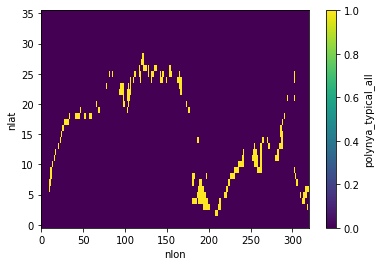

In [12]:
# Read in satellite polynya data
file_in = 'CESM_grid_SSMI_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_sat_pd = ds_poly.polynya_typical_all

# modify the mask for later calculations
poly_sat_pd = poly_sat_pd.fillna(0)

# test plot
poly_sat_pd.plot()

## Load map related masks for analysis

In [13]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [14]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPAs, MPA planning areas, AES)
ccamlr_in = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9',
             'Ross_mpa','Weddell_mpa','Ant_Peninsula_mpa','East_Ant_mpa',
             'AES']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod,
                          ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.Ross_mpa, ds_ccamlr.Weddell_mpa,
                          ds_ccamlr.Ant_Peninsula_mpa, ds_ccamlr.East_Ant_mpa,
                          ds_ccamlr.AES],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


## Calculate AEV stats
- 3 zones: whole region, in polynyas, outside polynyas
- Calculate area weighted average - SUM(TAREA * data)/SUM(TAREA)
- Calculate areaweighted standard deviation - https://www.statology.org/weighted-standard-deviation-excel/

### Hemispheric

In [15]:
# set AEV data to use
data_calc = eco_hemi

In [16]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [17]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

# print values
print('Hemispheric values:')
print('avg overall')
print(avg.values)
print('avg IN polynya')
print(poly_avg.values)
print('avg OUT polynya')
print(nopoly_avg.values)

Hemispheric values:
avg overall
0.2796010507350853
avg IN polynya
0.4274682077619588
avg OUT polynya
0.2729995970783855


### Regions - as a whole
- Not really the right way to do this as each region AEV baseline is independent

In [18]:
# set AEV data to use
data_calc = eco_pd

In [19]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [20]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

# print values
print(avg.values)
print(poly_avg.values)
print(nopoly_avg.values)

0.38115021572807484
0.5960823803094788
0.3716109704454681


### Regions - Weddell

In [21]:
# set AEV data to use
reg = 'mpa_plan_3_4'
data_calc = eco_pd * ccamlr_masks.sel(region=reg)

In [22]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [23]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

In [24]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

In [25]:
# set data for this region
wedd_avg = avg
wedd_poly_avg = poly_avg
wedd_nopoly_avg = nopoly_avg

wedd_std = std
wedd_poly_std = poly_std
wedd_nopoly_std = nopoly_std

### Regions - East Antarctica

In [26]:
# set AEV data to use
reg = 'mpa_plan_7_mod'
data_calc = eco_pd * ccamlr_masks.sel(region=reg)

In [27]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [28]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

In [29]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

In [30]:
# set data for this region
eant_avg = avg
eant_poly_avg = poly_avg
eant_nopoly_avg = nopoly_avg

eant_std = std
eant_poly_std = poly_std
eant_nopoly_std = nopoly_std

### Regions - Ross Sea

In [31]:
# set AEV data to use
reg = 'mpa_plan_8'
data_calc = eco_pd * ccamlr_masks.sel(region=reg)

In [32]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [33]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

In [34]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

In [35]:
# set data for this region
ross_avg = avg
ross_poly_avg = poly_avg
ross_nopoly_avg = nopoly_avg

ross_std = std
ross_poly_std = poly_std
ross_nopoly_std = nopoly_std

### Regions - Amundsen Sea

In [36]:
# set AEV data to use
reg = 'mpa_plan_9'
data_calc = eco_pd * ccamlr_masks.sel(region=reg)

In [37]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [38]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

In [39]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

In [40]:
# set data for this region
amun_avg = avg
amun_poly_avg = poly_avg
amun_nopoly_avg = nopoly_avg

amun_std = std
amun_poly_std = poly_std
amun_nopoly_std = nopoly_std

### Regions - Antarctic peninsula

In [41]:
# set AEV data to use
reg = 'mpa_plan_1_mod'
data_calc = eco_pd * ccamlr_masks.sel(region=reg)

In [42]:
# mask TAREA for each zone
tarea_eco = tarea.where(data_calc > 0)
tarea_poly = tarea.where((data_calc > 0) & (poly_sat_pd == 1))
tarea_nopoly = tarea.where((data_calc > 0) & (poly_sat_pd == 0))

In [43]:
# calculate area weighted AVERAGES for 3 zones
avg = ((tarea_eco*data_calc).sum(dim=["nlat", "nlon"])/tarea_eco.sum(dim=["nlat", "nlon"]))
poly_avg = ((tarea_poly*data_calc).sum(dim=["nlat", "nlon"])/tarea_poly.sum(dim=["nlat", "nlon"]))
nopoly_avg = ((tarea_nopoly*data_calc).sum(dim=["nlat", "nlon"])/tarea_nopoly.sum(dim=["nlat", "nlon"]))

In [44]:
# calculate weighted STANDARD DEVIATION for 3 zones

## All points
# numerator
num = (tarea_eco*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_eco.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_eco.sum(dim=["nlat", "nlon"])
# calculate standard deviation
std = (num/denom)**0.5

## IN polynyas
# numerator
num = (tarea_poly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_poly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_poly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
poly_std = (num/denom)**0.5

## OUT polynyas
# numerator
num = (tarea_nopoly*(data_calc-avg)**2).sum(dim=["nlat", "nlon"])
# total number of non-missing points
test = tarea_nopoly.stack(new=("nlat","nlon")).dropna(dim='new')
npts = len(test)
# denominator
denom = ((npts-1)/npts) * tarea_nopoly.sum(dim=["nlat", "nlon"])
# calculate standard deviation
nopoly_std = (num/denom)**0.5

In [45]:
# set data for this region
apen_avg = avg
apen_poly_avg = poly_avg
apen_nopoly_avg = nopoly_avg

apen_std = std
apen_poly_std = poly_std
apen_nopoly_std = nopoly_std

## Plot the results

- Want to have a plot of bar charts + variance bars

In [46]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'

In [47]:
# separate arrays for each of the values - easier plotting

## averages
avg_region = [wedd_avg.values, eant_avg.values, ross_avg.values, amun_avg.values, apen_avg.values]
avg_region = np.round_(avg_region,decimals=2)

avg_poly = [wedd_poly_avg.values, eant_poly_avg.values, ross_poly_avg.values, amun_poly_avg.values, apen_poly_avg.values]
avg_poly = np.round_(avg_poly,decimals=2)

avg_nopoly = [wedd_nopoly_avg.values, eant_nopoly_avg.values, ross_nopoly_avg.values, amun_nopoly_avg.values, apen_nopoly_avg.values]
avg_nopoly = np.round_(avg_nopoly,decimals=2)

## standard deviations
std_region = [wedd_std.values, eant_std.values, ross_std.values, amun_std.values, apen_std.values]
std_region = np.round_(std_region,decimals=2)

std_poly = [wedd_poly_std.values, eant_poly_std.values, ross_poly_std.values, amun_poly_std.values, apen_poly_std.values]
std_poly = np.round_(std_poly,decimals=2)

std_nopoly = [wedd_nopoly_std.values, eant_nopoly_std.values, ross_nopoly_std.values, amun_nopoly_std.values, apen_nopoly_std.values]
std_nopoly = np.round_(std_nopoly,decimals=2)

In [48]:
## Print data to include in a table

print('order: Weddell, E.Ant, Ross, Amundsen, Peninsula')
print('Whole regions')
print('Averages:')
print(avg_region)
print('Standard deviations:')
print(std_region)

print('INSIDE polynyas')
print('Averages:')
print(avg_poly)
print('Standard deviations:')
print(std_poly)

print('OUTSIDE polynyas')
print('Averages:')
print(avg_nopoly)
print('Standard deviations:')
print(std_nopoly)

order: Weddell, E.Ant, Ross, Amundsen, Peninsula
Whole regions
Averages:
[0.38 0.45 0.36 0.36 0.32]
Standard deviations:
[0.07 0.1  0.15 0.09 0.12]
INSIDE polynyas
Averages:
[0.52 0.62 0.73 0.52 0.52]
Standard deviations:
[0.24 0.24 0.42 0.24 0.29]
OUTSIDE polynyas
Averages:
[0.38 0.44 0.35 0.36 0.31]
Standard deviations:
[0.06 0.08 0.13 0.08 0.11]


In [49]:
fout = 'Figure_2_Ecoindex_avg_bars'

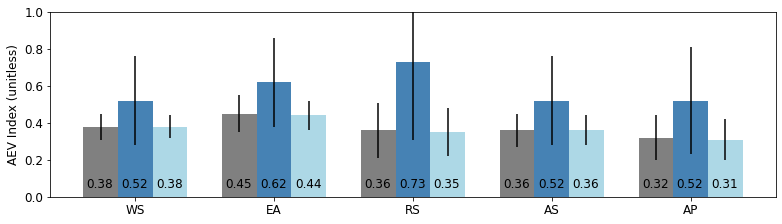

In [50]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_gridspec(6, 8)

ww = 0.25
offset1 = 0.25
offset2 = 0.5

# set x and y arrays to plot against
region = ("WS", "EA", "RS", "AS", "AP")
x = np.arange(len(region)) + 0.5  # the label locations
y = np.arange(0,1.2, 0.2)
y = np.round_(y,decimals=1)

# set up text to add later
x_tx = [0.25,1.25,2.25,3.25,4.25]
y_tx = [0.1,0.1,0.1,0.1,0.1]
tx_avg = [str(f) for f in avg_region]
#tx_poly = str(avg_poly)
#tx_nopoly = str(avg_nopoly)

### plot of average AEV values
ax = fig.add_subplot(ax[0:3,0:8])

# plot the average over entire region
pc=ax.bar(x,avg_region,yerr=std_region, width=ww, color='grey',label='Whole region')
#ax.bar_label(pc,fontsize=12)

# plot the average IN polynyas
pc=ax.bar(x+offset1,avg_poly,yerr=std_poly, width=ww, color='steelblue',label='INSIDE polynyas')
#ax.bar_label(pc,fontsize=12)

# plot the average OUT polynyas
pc=ax.bar(x+offset2,avg_nopoly,yerr=std_nopoly, width=ww, color='lightblue',label='OUTSIDE polynyas')
#ax.bar_label(pc,fontsize=12)

# Add labels for the values - do manually since it got weird
ax.text(0.4, 0.05, str(avg_region[0]),fontsize=12)
ax.text(1.4, 0.05, str(avg_region[1]),fontsize=12)
ax.text(2.4, 0.05, str(avg_region[2]),fontsize=12)
ax.text(3.4, 0.05, str(avg_region[3]),fontsize=12)
ax.text(4.4, 0.05, str(avg_region[4]),fontsize=12)
ax.text(0.65, 0.05, str(avg_poly[0]),fontsize=12)
ax.text(1.65, 0.05, str(avg_poly[1]),fontsize=12)
ax.text(2.65, 0.05, str(avg_poly[2]),fontsize=12)
ax.text(3.65, 0.05, str(avg_poly[3]),fontsize=12)
ax.text(4.65, 0.05, str(avg_poly[4]),fontsize=12)
ax.text(0.9, 0.05, str(avg_nopoly[0]),fontsize=12)
ax.text(1.9, 0.05, str(avg_nopoly[1]),fontsize=12)
ax.text(2.9, 0.05, str(avg_nopoly[2]),fontsize=12)
ax.text(3.9, 0.05, str(avg_nopoly[3]),fontsize=12)
ax.text(4.9, 0.05, str(avg_nopoly[4]),fontsize=12)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AEV Index (unitless)',fontsize=12)
ax.set_yticks(y, y, fontsize=12)
ax.set_ylim(0, 1.0)
ax.set_xticks(x + offset1, region, fontsize=12)
#ax.legend(loc='upper right', fontsize=12)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=400)

In [51]:
fout = 'Figure_2_bar_legend'

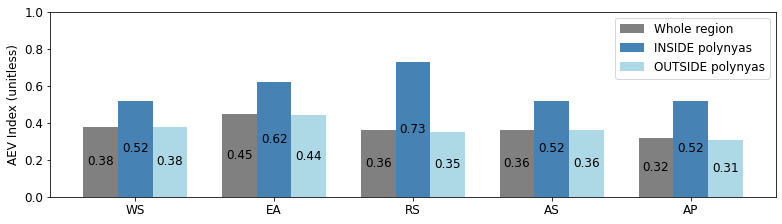

In [52]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_gridspec(6, 8)

ww = 0.25
offset1 = 0.25
offset2 = 0.5

# set x and y arrays to plot against
region = ("WS", "EA", "RS", "AS", "AP")
x = np.arange(len(region)) + 0.5  # the label locations
y = np.arange(0,1.2, 0.2)
y = np.round_(y,decimals=1)

### plot of average AEV values
ax = fig.add_subplot(ax[0:3,0:8])

# plot the average over entire region
pc=ax.bar(x,avg_region, width=ww, color='grey',label='Whole region')
ax.bar_label(pc, label_type='center',fontsize=12)

# plot the average IN polynyas
pc=ax.bar(x+offset1,avg_poly, width=ww, color='steelblue',label='INSIDE polynyas')
ax.bar_label(pc, label_type='center',fontsize=12)

# plot the average OUT polynyas
pc=ax.bar(x+offset2,avg_nopoly, width=ww, color='lightblue',label='OUTSIDE polynyas')
ax.bar_label(pc, label_type='center',fontsize=12)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AEV Index (unitless)',fontsize=12)
#ax.set_title('AEV Index average values',fontsize=12)
ax.set_xticks(x + offset1, region, fontsize=12)
ax.set_yticks(y, y, fontsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.set_ylim(0, 1.0)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=400)

## Combine into single arrays

In [53]:
region = ("Weddell\nSea", "East\nAntarctica", "Ross\nSea", "Amundsen\nSea", "Antarctic\nPeninsula")
regional_means = {
    'Whole Region': (wedd_avg, eant_avg, ross_avg, amun_avg, apen_avg),
    'Inside Polynya': (wedd_poly_avg, eant_poly_avg, ross_poly_avg, amun_poly_avg, apen_poly_avg),
    'Outside Polynya': (wedd_nopoly_avg, eant_nopoly_avg, ross_nopoly_avg, amun_nopoly_avg, apen_nopoly_avg),
}

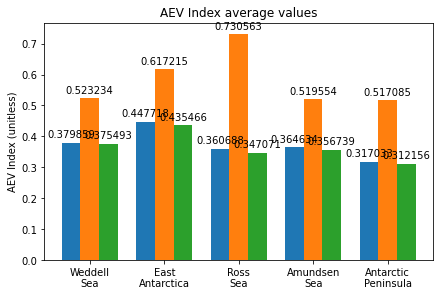

In [54]:
x = np.arange(len(region))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in regional_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AEV Index (unitless)')
ax.set_title('AEV Index average values')
ax.set_xticks(x + width, region)
#ax.legend(loc='upper left', ncols=5)
#ax.set_ylim(0, 1.0)

plt.show()